In [ ]:
!pip install selenium
!apt install chrome
!pip install fake_useragent
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from fake_useragent import UserAgent
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import TimeoutException
!pip install nltk
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
!pip install tqdm
from tqdm import tqdm
from google.colab import files
import sqlite3
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 13.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package chrome
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
conn = sqlite3.connect('reviews_general.db')
c = conn.cursor()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment")
model = AutoModelForSequenceClassification.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

In [ ]:
options = Options()
options.add_argument('--headless')
ua = UserAgent()
user_agent = "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"
options.add_argument(f'user-agent={user_agent}')

Определение оптимального ограничения длины отзыва

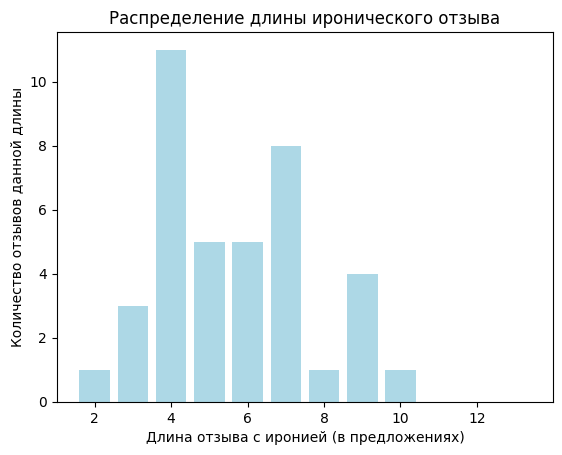

In [ ]:
length = {}
for sarc in sarcastic:
  le = len(sent_tokenize(sarc))
  if le in length.keys():
    length[le]+=1
  else:
    length[le]=0

plt.bar(list(length.keys()), list(length.values()), color='lightblue')
plt.title('Распределение длины иронического отзыва')
plt.ylabel('Количество отзывов данной длины')
plt.xlabel('Длина отзыва с иронией (в предложениях)')
plt.show() #берём ограничение 5 по этому распределению по 30 отзывам на все товары

In [ ]:
def sentiment(sent:str):#определение класса сентимента предложения
  inputs = tokenizer(sent, return_tensors='pt')
  with torch.no_grad():
      logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()
  return predicted_class_id #0 -- отрицательный, 1 -- нейтральный, 2 -- положительный

In [ ]:
def polozh_check(text): # проверка на положительность
  sent_text = sent_tokenize(text)
  if len(sent_text)>5:
    return False
  if sentiment(text)!=0:
    return True
  return False

In [ ]:
def data_pos(link): #краулеринг положительных отзывов
  driver = webdriver.Firefox(options=options)
  driver.get(link)
  search = []
  id = 0
  while len(set(search)) <= 100:
    li = [element.text.replace('Читать отзыв', '') for element in list(driver.find_elements(By.CLASS_NAME, "review-snippet")) if polozh_check(element.text)]
    try:
      search_btn = driver.find_element(By.CLASS_NAME, 'my_pagination')
      search_btn.click()
    except ElementClickInterceptedException:
      driver.implicitly_wait(5)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    search.extend(li)
  search = set(search)
  for i in search: #добавление положительных отзывов в датасет
    c.execute('CREATE TABLE IF NOT EXISTS Positives (id_n integer, text_n text)')
    record = (id, i)
    c.execute("INSERT INTO Positives VALUES (?, ?)", record)
    conn.commit()
    id += 1

In [ ]:
# список положительных ссылок
polozh = ['https://www.otzyvru.com/dpd?sort=rating_desc',
          'https://www.otzyvru.com/rossiyskie-jeleznye-dorogi?sort=rating_desc',
          'https://www.otzyvru.com/rostelekom?sort=rating_desc',
          'https://www.otzyvru.com/yandeks-taksi?sort=rating_desc',
          'https://www.otzyvru.com/detskiy-mir?sort=rating_desc',
          'https://www.otzyvru.com/mts?sort=rating_desc',
          'https://www.otzyvru.com/match-tv?sort=rating_desc',
          'https://www.otzyvru.com/sdek?sort=rating_desc',
          'https://www.otzyvru.com/ozonru?sort=rating_desc',
          'https://www.otzyvru.com/avitoru?sort=rating_desc',
          'https://www.otzyvru.com/sbermarket?sort=rating_desc',
          'https://www.otzyvru.com/yandekseda?sort=rating_desc',
          'https://www.otzyvru.com/megafon?sort=rating_desc',
          'https://www.otzyvru.com/mebelnaya-fabrika-mnogo-mebeli?sort=rating_desc',
          'https://www.otzyvru.com/sberbank-rossii?sort=rating_desc',
          'https://www.otzyvru.com/wildberriesru?sort=rating_desc',
          'https://www.otzyvru.com/pleerru?sort=rating_desc',
          'https://www.otzyvru.com/golos-perviy-kanal?sort=rating_desc',
          'https://www.otzyvru.com/peredacha-60-minut?sort=rating_desc',
          'https://www.otzyvru.com/sovkombank?sort=rating_desc']

In [ ]:
for p in tqdm(polozh):
  data_pos(p)

100%|██████████| 20/20 [1:24:39<00:00, 253.96s/it]


In [ ]:
# список негативных ссылок
negative =['https://www.otzyvru.com/dpd?sort=rating_desc',
          'https://www.otzyvru.com/rossiyskie-jeleznye-dorogi?sort=rating_asc',
          'https://www.otzyvru.com/rostelekom?sort=rating_asc',
          'https://www.otzyvru.com/yandeks-taksi?sort=rating_asc',
          'https://www.otzyvru.com/detskiy-mir?sort=rating_asc',
          'https://www.otzyvru.com/mts?sort=rating_asc',
          'https://www.otzyvru.com/match-tv?sort=rating_asc',
          'https://www.otzyvru.com/sdek?sort=rating_asc',
          'https://www.otzyvru.com/ozonru?sort=rating_asc',
          'https://www.otzyvru.com/avitoru?sort=rating_asc',
          'https://www.otzyvru.com/sbermarket?sort=rating_asc',
          'https://www.otzyvru.com/yandekseda?sort=rating_asc',
          'https://www.otzyvru.com/megafon?sort=rating_asc',
          'https://www.otzyvru.com/mebelnaya-fabrika-mnogo-mebeli?sort=rating_asc',
          'https://www.otzyvru.com/sberbank-rossii?sort=rating_asc',
          'https://www.otzyvru.com/wildberriesru?sort=rating_asc',
          'https://www.otzyvru.com/pleerru?sort=rating_asc',
          'https://www.otzyvru.com/golos-perviy-kanal?sort=rating_asc',
          'https://www.otzyvru.com/peredacha-60-minut?sort=rating_asc',
          'https://www.otzyvru.com/sovkombank?sort=rating_asc']

In [ ]:
def sentence_sentiment(text): # проверка отзыва на саркастичность
  sent_text = sent_tokenize(text)
  if len(sent_text)>5:
      return False
  if sentiment(text)!=2: # общее настроение не положительное
    for sentence in sent_text:
      if sentiment(sentence) == 2: #при этом есть положительное предложение
        return True
  return False

In [ ]:
def data_neg_2(link,number): #краулеринг негативных отзывов
  driver = webdriver.Firefox(options=options)
  driver.get(link)
  ignored_exceptions=(ElementClickInterceptedException, StaleElementReferenceException,TimeoutException)
  wait = WebDriverWait(driver, timeout=10, ignored_exceptions=ignored_exceptions)
  for i in tqdm(range(300)):
    try:
      elem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'my_pagination')))
      search_btn = driver.find_element(By.CLASS_NAME, 'my_pagination')
      search_btn.click()
    except (ElementClickInterceptedException, StaleElementReferenceException):
      driver.save_screenshot('screenie.png')
    except TimeoutException:
      driver.implicitly_wait(15)
  driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
  li = set([element.text.replace('Читать отзыв', '') for element in list(driver.find_elements(By.CLASS_NAME, "review-snippet"))])
  with open(f'info{number}.txt', 'a+', encoding='utf-8') as f:
    for i in li:
      f.write(i+"|||")

In [ ]:
for site in range(len(negative)):
  data_neg_2(neg[site],site)
  files.download(f'info{10+site}.txt')

100%|██████████| 300/300 [18:07<00:00,  3.62s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [02:04<00:00,  2.40it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [03:15<00:00,  1.53it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# выявление саркастических отзывов
for i in tqdm(range(1,18)):
  with open(f"info{i}.txt", 'r', encoding='utf-8') as f:
    lines = ''.join(f.readlines()).split("|||")
    new_lines = [line for line in lines if sentence_sentiment(line)]
  with open(f"sarcasm{i}.txt", 'w', encoding='utf-8') as f:
    for new in new_lines:
      f.write(new+"|||")
  files.download(f"sarcasm{i}.txt")


  0%|          | 0/17 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  6%|▌         | 1/17 [01:20<21:22, 80.17s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 12%|█▏        | 2/17 [25:20<3:39:59, 879.99s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 18%|█▊        | 3/17 [26:28<1:58:53, 509.50s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 24%|██▎       | 4/17 [27:43<1:13:13, 337.96s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 29%|██▉       | 5/17 [29:01<48:51, 244.28s/it]  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 35%|███▌      | 6/17 [30:49<36:17, 197.97s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 41%|████      | 7/17 [31:42<25:04, 150.45s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 47%|████▋     | 8/17 [32:31<17:43, 118.13s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 53%|█████▎    | 9/17 [54:58<1:06:59, 502.42s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 59%|█████▉    | 10/17 [58:07<47:19, 405.70s/it] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 65%|██████▍   | 11/17 [1:10:40<51:10, 511.70s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 71%|███████   | 12/17 [1:12:03<31:47, 381.49s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 76%|███████▋  | 13/17 [1:13:10<19:04, 286.09s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 82%|████████▏ | 14/17 [1:30:10<25:23, 507.73s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 88%|████████▊ | 15/17 [1:32:46<13:23, 401.74s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 94%|█████████▍| 16/17 [1:33:36<04:56, 296.09s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 17/17 [1:54:53<00:00, 405.47s/it]


In [ ]:
#добавление саркастических отзывов в датабазу
with open('sarcasm_general.txt', 'r', encoding='utf-8') as f:
  sarc = ''.join(f.readlines()).split("|||")
  id = 0
  for s in sarc:
    c.execute('CREATE TABLE IF NOT EXISTS Negatives (id_n integer, text_n text)')
    record = (id, s)
    c.execute("INSERT INTO Negatives VALUES (?, ?)", record)
    conn.commit()
    id += 1